In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

t = time.time()

# 0 - Création des fonctions utiles

In [2]:
def sentiment140(stop_words, lemmatization, negation, nb_data):
    """Fonction permettant d'ouvrir un échantillon de la base Sentiment140 préprocessée avec la combinaison 
    de booléens (stop_words, lemmatization, negation)"""
    
    file = "train"
    if stop_words:
        file += "_stop"
    if lemmatization:
        file += "_lemm"
    if negation:
        file += "_neg"
    return pd.read_pickle(os.path.join("data", "Sentiment140", file + ".bz2")).sample(nb_data, random_state=1234)

In [3]:
sentiment140(False, False, False, 10)

,sentiment,id,date,query_string,user,text
599410,0,2220663113,Thu Jun 18 03:39:49 PDT 2009,NO_QUERY,gemgembam,open itunes will not open naooo the silence is...
549856,0,2202759103,Tue Jun 16 22:21:43 PDT 2009,NO_QUERY,twistofcolour,the sun is already gone for the day
1363048,4,2049441111,Fri Jun 05 16:53:10 PDT 2009,NO_QUERY,Niico1e,hiya this is my st tweet i am so tired though ...
558776,0,2204830292,Wed Jun 17 03:14:38 PDT 2009,NO_QUERY,MeriEsteban,i have the bac today at p m i do not know if i...
1582398,4,2190306594,Tue Jun 16 02:21:03 PDT 2009,NO_QUERY,MeghanMagnolia,as far as i remember you were not half bad ine...
1353343,4,2046706853,Fri Jun 05 12:34:26 PDT 2009,NO_QUERY,WahooPooh,as tempting as that is i am just waiting on my...
586354,0,2215937155,Wed Jun 17 18:49:10 PDT 2009,NO_QUERY,amandarie,cool how i have to be stuck at home i want to ...
860355,4,1676343245,Fri May 01 21:46:07 PDT 2009,NO_QUERY,MatchesMalone,oh and followfriday my writing partner because...
521668,0,2192486836,Tue Jun 16 07:06:35 PDT 2009,NO_QUERY,hockeyfan45214,you would think if i continue to block someone...
243888,0,1981647618,Sun May 31 09:35:54 PDT 2009,NO_QUERY,ilovemytroops,nevaeh buchanan missing friends of her mother ...


In [4]:
class Modelisation():
    """Classe permettant d'entrainer un modèle et de l'évaluer"""
    
    def __init__(self, X, y, vectorizer, model, scaling=True):
        X = vectorizer.fit_transform(X)

        if scaling:
            scaler = StandardScaler(with_mean=False)
            X = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1234)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        sc_accuracy = metrics.accuracy_score(y_pred, y_test)    
        sc_balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)
        sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        probs = model.predict_proba(X_test)[:, 1]

        metrics_score = {'accuracy': sc_accuracy, 'balanced_accuracy': sc_balanced_accuracy, 'roc_auc': sc_roc_auc}

        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        self.model = model
        self.probs = probs
        self.metrics_score = metrics_score
    
    def get_data(self):
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def show_conf_matrix(self):
        metrics.plot_confusion_matrix(self.model, self.X_test, self.y_test, cmap='Blues')
        plt.show()

        print(f"Accuracy : {self.metrics_score['accuracy']:.4f}")
        print(f"Balanced accuracy : {self.metrics_score['balanced_accuracy']:.4f}")
        print(f"ROC AUC : {self.metrics_score['roc_auc']:.4f}")

In [5]:
def comparaison(X, y, N, model, scaling=True, show_graph=True):
    """
    Création d'un DataFrame qui contient les performances des différents couples (vectorizer, model) étudiés
    Les performances regardées sont l'aire sous la courbe ROC, la précision et la "balanced accuracy"
    N correspond au nombre de features que vont utiliser les vectorizers
    """
    table = []
    
    m = Modelisation(X, y, CountVectorizer(max_features = N), model)
    table.append(m.metrics_score)

    m = Modelisation(X, y, TfidfVectorizer(max_features = N), model)
    table.append(m.metrics_score)

    m = Modelisation(X, y, CountVectorizer(max_features = N, ngram_range=(1,2)), model)
    table.append(m.metrics_score)

    m = Modelisation(X, y, TfidfVectorizer(max_features = N, ngram_range=(1,2)), model)
    table.append(m.metrics_score)
    
    
    df = pd.DataFrame(table, index=[f"CountVectorizer {N}", f"TfidfVectorizer {N}", f"CountVectorizer {N} ngram 2", f"TfidfVectorizer {N} ngram 2"])
    
    return df

In [6]:
def influence_preprocessing(N, model, show_graph=False, show_table=False):
    """Création d'un DataFrame qui regroupe les performances des couples (vectorizer, model) sur les différents 
    "états de preprocessing" de la base Sentiment140, en fonction de la combinaison (stop_words, lemmatization, negation) """
    
    tables = []
    for stop_words in [False, True]:
        for lemmatization in [False, True]:
            for negation in [False, True]:
                print(f"stop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}")
                df_temp = sentiment140(stop_words, lemmatization, negation, NB_DATA)
                X = df_temp.text.to_list()
                y = df_temp.sentiment.to_list()            
                df_metrics = comparaison(X, y, N, model, show_graph=show_graph)
                if show_table:
                    display(df_metrics)
                df_metrics['stop_words'] = stop_words
                df_metrics['lemmatization'] = lemmatization
                df_metrics['negation'] = negation
                tables.append(df_metrics)
    return pd.concat(tables)

In [7]:
def influence_features(X, y, max_features_list, model, scaling=True):
    """Comparaison des performances des couples (vectorizer, model) en faisant varier le nombre de features"""
    
    table = []
    for max_features in max_features_list:
        m = Modelisation(X, y, CountVectorizer(max_features=max_features), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "CountVectorizer"
        table.append(metrics_score)

        m = Modelisation(X, y, TfidfVectorizer(max_features=max_features), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "TfidfVectorizer"
        table.append(metrics_score)

        m = Modelisation(X, y, CountVectorizer(max_features=max_features, ngram_range=(1, 2)), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "CountVectorizer ngram 2"
        table.append(metrics_score)

        m = Modelisation(X, y, TfidfVectorizer(max_features=max_features, ngram_range=(1, 2)), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "TfidfVectorizer ngram 2"
        table.append(metrics_score)

    df = pd.DataFrame(table)

    methods = list(set(df.method))
    scores = list(df.columns[:-2])
    fig, axes = plt.subplots(1, len(scores), figsize=(20, 6))
    for i_score in range(len(scores)):
        for j_method in range(len(methods)):
            df[df.method == methods[j_method]].plot(x='features', y=scores[i_score], label=methods[j_method], ax=axes[i_score])
        axes[i_score].set(xlabel='Nombre de features')
        axes[i_score].legend()
        axes[i_score].set_title(scores[i_score])
    plt.show()
    return df

# 1 - Sélection des meilleurs paramètres du modèle Logistic Regression

On commence par choisir le nombre de lignes que l'on extrait de la base Sentiment140, sur laquelle on va entraîner et évaluer notre modèle.

In [8]:
NB_DATA = 50000

## 1.1 - Comparaison des méthodes de preprocessing et de "feature extraction" (vectorizer)

In [9]:
%%time
df_metrics = influence_preprocessing(2500, LogisticRegression(max_iter=100000))

stop_words: False, lemmatization: False, negation: False
stop_words: False, lemmatization: False, negation: True
stop_words: False, lemmatization: True, negation: False
stop_words: False, lemmatization: True, negation: True
stop_words: True, lemmatization: False, negation: False
stop_words: True, lemmatization: False, negation: True
stop_words: True, lemmatization: True, negation: False
stop_words: True, lemmatization: True, negation: True
Wall time: 3min 4s


In [10]:
df_metrics.sort_values(by="roc_auc", ascending=False)

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
TfidfVectorizer 2500 ngram 2,0.7690,0.769546,0.849718,False,True,False
TfidfVectorizer 2500 ngram 2,0.7676,0.768166,0.847014,False,False,False
TfidfVectorizer 2500,0.7595,0.759925,0.845374,False,True,True
TfidfVectorizer 2500,0.7641,0.764576,0.845358,False,False,True
TfidfVectorizer 2500,0.7641,0.764490,0.844999,False,False,False
TfidfVectorizer 2500 ngram 2,0.7622,0.763052,0.843606,False,True,True
TfidfVectorizer 2500,0.7587,0.759043,0.843216,False,True,False
CountVectorizer 2500 ngram 2,0.7690,0.770321,0.842537,False,True,False
TfidfVectorizer 2500 ngram 2,0.7630,0.763778,0.842365,False,False,True
CountVectorizer 2500 ngram 2,0.7655,0.766850,0.840311,False,False,False


In [11]:
df_metrics.sort_values(by="balanced_accuracy", ascending=False)

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
CountVectorizer 2500 ngram 2,0.7690,0.770321,0.842537,False,True,False
TfidfVectorizer 2500 ngram 2,0.7690,0.769546,0.849718,False,True,False
TfidfVectorizer 2500 ngram 2,0.7676,0.768166,0.847014,False,False,False
CountVectorizer 2500 ngram 2,0.7655,0.766850,0.840311,False,False,False
TfidfVectorizer 2500,0.7641,0.764576,0.845358,False,False,True
TfidfVectorizer 2500,0.7641,0.764490,0.844999,False,False,False
CountVectorizer 2500,0.7633,0.764461,0.837683,False,False,True
TfidfVectorizer 2500 ngram 2,0.7630,0.763778,0.842365,False,False,True
CountVectorizer 2500 ngram 2,0.7617,0.763102,0.836785,False,True,True
TfidfVectorizer 2500 ngram 2,0.7622,0.763052,0.843606,False,True,True


In [12]:
df_metrics.sort_values(by="accuracy", ascending=False)

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
CountVectorizer 2500 ngram 2,0.7690,0.770321,0.842537,False,True,False
TfidfVectorizer 2500 ngram 2,0.7690,0.769546,0.849718,False,True,False
TfidfVectorizer 2500 ngram 2,0.7676,0.768166,0.847014,False,False,False
CountVectorizer 2500 ngram 2,0.7655,0.766850,0.840311,False,False,False
TfidfVectorizer 2500,0.7641,0.764490,0.844999,False,False,False
TfidfVectorizer 2500,0.7641,0.764576,0.845358,False,False,True
CountVectorizer 2500,0.7633,0.764461,0.837683,False,False,True
TfidfVectorizer 2500 ngram 2,0.7630,0.763778,0.842365,False,False,True
TfidfVectorizer 2500 ngram 2,0.7622,0.763052,0.843606,False,True,True
CountVectorizer 2500,0.7618,0.762782,0.837304,False,False,False


Pour N=500, la combinaison optimale semble être stop_words=False, lemmatization=True, negation=False

Cependant, N=500 est un nombre de features assez faible. Il est donc pertinent de regarder si de nouvelles tendances se dégagent lorsque l'on fait augmenter le nombre de features N.

Pour N=1000, la combinaison optimale est de nouveau stop_words=False, lemmatization=True, negation=False

Pour N=2500, la combinaison optimale est encore stop_words=False, lemmatization=True, negation=False

Finalement, pour la suite, nous retiendrons la combinaison stop_words=False, lemmatization=True, negation=False

Enfin, il apparaît que le vectorizer le plus performant est le TfidfVectorizer avec ngram. Pour la combinaison qui nous intéresse (stop_words=False, lemmatization=True, negation=False), ce vectorizer est presque toujours le plus performant.

## Paramètres retenus :

In [13]:
%%time
NB_DATA = 50000
STOP_WORDS = False
LEMMATIZATION = True
NEGATION = False

df = sentiment140(STOP_WORDS, LEMMATIZATION, NEGATION, NB_DATA)
X = df.text.to_list()
y = df.sentiment.to_list()

Wall time: 11.8 s


## 1.2 - Comparaison par rapport au nombre de features

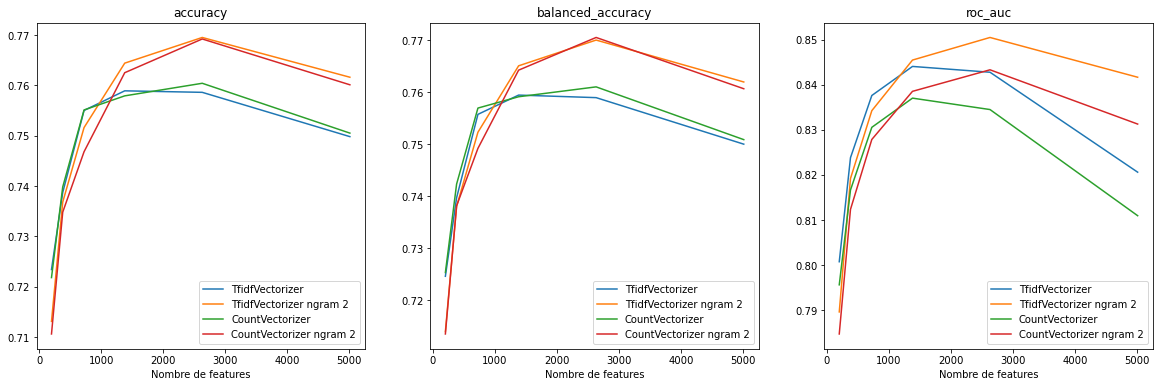

Wall time: 49.4 s


,accuracy,balanced_accuracy,roc_auc,features,method
0,0.7218,0.725297,0.795604,199,CountVectorizer
1,0.7234,0.724577,0.800729,199,TfidfVectorizer
2,0.7106,0.713485,0.784691,199,CountVectorizer ngram 2
3,0.7131,0.713956,0.789587,199,TfidfVectorizer ngram 2
4,0.7398,0.742304,0.816651,380,CountVectorizer
5,0.7387,0.739681,0.823818,380,TfidfVectorizer
6,0.7348,0.738131,0.812344,380,CountVectorizer ngram 2
7,0.7368,0.737986,0.819207,380,TfidfVectorizer ngram 2
8,0.7551,0.756917,0.830562,724,CountVectorizer
9,0.7550,0.755708,0.837628,724,TfidfVectorizer


In [14]:
%%time
max_features_list = np.logspace(2.3, 3.7, 6, endpoint=True, dtype=int)
influence_features(X, y, max_features_list, LogisticRegression(max_iter=1000000))

Comme annoncé précédemment, le vectorizer le plus performant est le TfidfVectorizer avec ngram. C'est donc ce vectorizer que nous utiliserons pour nos estimations futures.

## 1.3 - GridSearch pour obtenir les meilleurs paramètres

On choisit les paramètres au vu des études précédentes

In [15]:

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1234)

In [16]:
%%time
#Tfidfvectorizer
text_clf = Pipeline([('idf', TfidfVectorizer()), ('clf', LogisticRegression(max_iter=1000000, random_state=1234))])
nb_max_words = len(TfidfVectorizer().fit(X_train).get_feature_names())

parameters = {'idf__max_features' : np.logspace(2.3, np.log10(nb_max_words), 6, endpoint=True, dtype=int),
           'idf__ngram_range' : [(1,1),(1,2)],
           'clf__C' : np.logspace(-3,3,7)
}

grid_clf = GridSearchCV(text_clf, parameters, scoring='balanced_accuracy', cv=5)
_ = grid_clf.fit(X_train, y_train)

print('Balanced Accuracy : %.3f' % grid_clf.best_estimator_.score(X_train, y_train))
print('Best Balanced Accuracy Through Grid Search : %.3f' % grid_clf.best_score_)
print('Best Parameters : ', grid_clf.best_params_)

Balanced Accuracy : 0.851
Best Balanced Accuracy Through Grid Search : 0.781
Best Parameters :  {'clf__C': 1.0, 'idf__max_features': 26211, 'idf__ngram_range': (1, 2)}
Wall time: 18min 28s


# 2 - Estimation finale du modèle

On applique finalement le modèle avec les paramètres suggérés par le GridSearch.

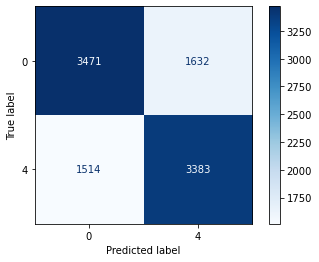

Accuracy : 0.6854
Balanced accuracy : 0.6854
ROC AUC : 0.7417
Wall time: 9.16 s


In [17]:
%%time
m = Modelisation(X, y, TfidfVectorizer(max_features=26211, ngram_range=(1,2)), LogisticRegression(C=1, max_iter=1000000, random_state=1234))
m.show_conf_matrix()

Les résultats obtenus avec les paramètres suggérés par le GridSearch ne sont pas très bons. Ils sont nettement meilleurs lorsque le nombre maximal de features vaut 2725.

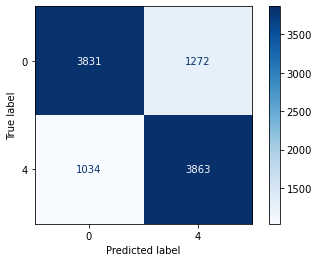

Accuracy : 0.7694
Balanced accuracy : 0.7699
ROC AUC : 0.8492
Wall time: 4.08 s


In [18]:
%%time
m = Modelisation(X, y, TfidfVectorizer(max_features=2725, ngram_range=(1,2)), LogisticRegression(C=1, max_iter=1000000, random_state=1234))
m.show_conf_matrix()

En conclusion, le modèle "LogisticRegression" couplé à la méthode de "feature extraction" TfidfVectorizer avec ngram donne les meilleurs résultats, tous modèles confondus. 

La précision ainsi obtenue avoisine les 77%, contre 74,3% et 73,4% pour les modèles faisant intervenir la classification bayésienne.

Nous utiliserons donc les outils suivants pour traiter notre base webscrapée :

- modèle : LogisticRegression(max_iter=1000000, random_state=1234)
- vectorizer : TfidfVectorizer(max_features=2725, ngram_range=(1, 2))
- combinaison : stop_words=False, lemmatization=True, negation=False

In [19]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:23:01
